# Word Embeddings
In this notebook, we will implement and train word2vec using the Skip-Gram model and word2vec using the CBOW model in TensorFlow. We will also investigate the behavior of pretrained GloVe embeddings models on an analogy task. This notebook is adapted from https://www.tensorflow.org/tutorials/word2vec.

## Set Up Helpers

In [2]:
%matplotlib inline

import collections
from functools import partial
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange

import tensorflow as tf

# Helper TensorFlow functions
from utils import get_session, maybe_download

/Users/Ched/info/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Download Data and Parameters

In [3]:
maybe_download('http://mattmahoney.net/dc/text8.zip', 'datasets', 31344016)
maybe_download('http://download.tensorflow.org/data/questions-words.txt', 'datasets', 603955)
maybe_download('http://nlp.stanford.edu/data/glove.6B.zip', 'datasets', 862182613)
if not os.path.exists(os.path.join("datasets", "glove.6B.50d.txt")):
    with zipfile.ZipFile(os.path.join("datasets", "glove.6B.zip"), "r") as zip_ref:
        zip_ref.extractall("datasets")
    for f in ["glove.6B.100d.txt", "glove.6B.300d.txt", "glove.6B.200d.txt"]:
        os.remove(os.path.join('datasets', f))

Found and verified datasets/text8.zip
Found and verified datasets/questions-words.txt
Found and verified datasets/glove.6B.zip


## Setup Up Data

In [4]:
# Read the data into a list of strings.
def read_vocabulary(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_vocabulary(os.path.join('datasets', 'text8.zip'))
print('Number of vocabulary items:', len(vocabulary))

# Build the dictionary and replace rare words with UNK token.
vocab_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, 
                                                            vocab_size)
del vocabulary  # To reduce memory consumption
print('Most common words (+UNK):', count[:5])
print('Sample data:', data[:10], [reverse_dictionary[i] for i in data[:10]])

Number of vocabulary items: 17005207
Most common words (+UNK): [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


# Why use word embeddings?

A **word embedding** $W: \{1, \dots, N\} \to \mathbb{R}^n$ is a parametric function that maps a word type to a high-dimensional vector. Typically, the function is a simple lookup table parameterized by a matrix $\mathbf{W}$, with a new row for each word type; the query $W(i)$ will return the $i$th row of $\mathbf{W}$. As usual in the machine learning paradigm, $\mathbf{W}$ is initialized randomly, and trained to produce small cost under some objective function.

**What's the motivation for using word embeddings?** We have seen that image processing systems work with complex data encoded as vectors of pixel intensities. On the other hand, traditional NLP systems used to treat words as symbolic tokens. These symbols are arbitrary, and don't provide information about the relationships that may exist between the individual symbols.

To solve these issues, vector space models represent -- or *embed* -- words into a continuous vector space that minimizes distances between semantically similar words.
Predictive vector space models implement this principle by trying to predict a word from its neighbors (or vice versa) in terms of learned embedding vectors that are considered parameters of the model.

In the following, we investigate some different ways of learning word embeddings.

# word2vec with NCE
In classic neural probabilistic  language models (and in tutorial), we use a maximum likelihood criterion to estimate the parameters of a model that computes a vector representation $u_i$ for a word $w_i$ as well as a contextual representation $v_j$ for a history $h_j$ (which could simply be the representation of the preceding word in a unigram model, or a more complex summary of the context). We assume a multinomial distribution over $w_i$, and thus the likelihood objective is a softmax function:

$$\begin{align}
P(w_i | h_j) &= \frac{\exp \{ u_{i} \cdot v_{j} \} }
             {\sum_{k=1}^{|\mathcal{V}|} \exp \{ u_{k} \cdot v_{j} \} }~.
             \tag{1}
\end{align}$$

**But this is very expensive to compute!** At every timestep $t$ and for each word $w_i$, we need to compute the normalization and sum over words in the vocabulary $\mathcal{V}$, which could be extremely large (often around $10^5$ to $10^7$ terms). Luckily, we can use a method called *noise-contrastive estimation* (NCE) so that we needn't use the full probabilistic model as above, but instead use a binary classification objective. The insight is to try to discriminate the target word $w_i$ from randomly sampled *noise* words $\tilde{w} \sim p_\text{noise}(w)$. The noise distribution $p_\text{noise}(w)$ is often chosen to be the uniform distribution over all words in the vocabulary.

NCE can be shown to approximately maximize the log probability of the full softmax in (1); you can check out the original paper that applied NCE to general unnormalized probability models [1] and or its first application to language modeling [2]. In practice, word embedding training procedures use a slightly modified version of the NCE objective, called *negative sampling* (NS), introduced in [3], in which samples from the noise distribution are strictly *negative* examples (i.e., not $w_i$). Consider the NS objective for a single word-context $w_i$-$h_j$ pair:

$$\ell_\text{NS} (w_i, h_j)
= - \left[\log p_\theta (D=1 | w_i, h_j) +
  k \mathop{\mathbb{E}}_{\tilde w \sim p_\text{noise}}
  \left[ \log p_\theta(D = 0 |\tilde{w}, h_j) \right]\right]~$$

which you can identify as logistic regression applied to the task of distinguishing the target word $w_i$ from draws from the noise distribution $p_\text{noise}(w)$. (For an optional, more in-depth explanation, see [this tutorial](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html#noise-contrastive-estimation-nce).)

To compute the NS loss for word2vec, we parameterize a sigmoid function output as follows:

$$% <![CDATA[
\begin{align}
p_{U,V} (D=1 | w_i, h_j) &= \sigma({u_{i}} \cdot v_{j}) \\
p_{U,V} (D = 0 |w_k, h_j) &= 1 - \sigma({u_{k}} \cdot v_{j}) = \sigma(-{u_{k}}\cdot v_{j})
\end{align} %]]>$$

where $u_i$ and $u_k$ are computed from the target embedding matrix $U$ and $v_{j}$ is computed from the context embedding matrix $V$. The NS loss becomes:

$$- [ \log \sigma({u_i}\cdot v_{j}) +  \sum_{\substack{k=1 \\ w_k \sim p_\text{noise}}}^N \log \sigma(-{u_{k}}\cdot v_{j})]~.\tag{2}$$

**For the word2vec models below, implement the NS objective (2) instead of the full probabilistic model (1).** You will implement the minibatch version that computes the average loss over some number of word-context $w_i$-$h_j$ paris. *Hint*: You may find that using the same batch of noise targets for every element $u_i$ of the target minibatch is sufficient and makes the implementation more efficient.

## Q1A. word2vec with CBOW
First off, we'll consider the Continuous Bag-of-Words (CBOW) model of word embeddings (introduced in Section 3.1 in Mikolov et al.). CBOW predicts a target word from its source context words (for example "in the hat" predicts "cat"). Since the source context is treated as a single observation, CBOW tends to neglect specific cooccurences of word types (in contrast to the Skip-Gram model, as we will discuss later).

**For this question, implement the computational graph that computes the NCE objective for the word2vec CBOW model. Do NOT make use of higher-level primitives from the tf.nn module.**

In [47]:
cbow_data_index = 0

def generate_batch_cbow(data, batch_size, context_window=1):
    """Generate a batch of examples and targets for use in the CBOW model."""
    global cbow_data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[cbow_data_index])
        cbow_data_index = (cbow_data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[cbow_data_index])
        cbow_data_index = (cbow_data_index + 1) % len(data)
    return batch, labels

def word2vec_cbow(vocab_size, embed_size, num_noise_samples=64, context_size=2, name='word2vec_cbow'):
    
    with tf.variable_scope(name):
        
        train_inputs = tf.placeholder(tf.int32, shape=[None, context_size])
        train_labels = tf.placeholder(tf.int32, shape=[None, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
        ### YOUR CODE HERE
        ### Make sure all variable definitions are within the scope!
        ### Implement the NCE loss as a logistic regression objective
        ### that discriminates noise from data samples
        """
        #initialization 
        embeddings = tf.Variable(tf.random_normal([vocab_size,embed_size]))
        
        #sampling 
        index = list(np.random.choice(list(range(vocab_size)),num_noise_samples))
        idx = tf.constant(index)
        sampled_rows = tf.gather(embeddings, idx)
        
        #train embedding
        train_rows = tf.gather(embeddings, train_inputs)
        
        
        
        #raise NotImplementedError("Need to implement the word2vec CBOW objective.")
        """
        #initialization 
        embeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        context_embedding =  tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        inputs= tf.reduce_mean(tf.gather(context_embedding,train_inputs),axis=1) 
        embed_labels = tf.gather(embeddings, train_labels)
        c= tf.squeeze(embed_labels,[1])
        loss = tf.reduce_mean(tf.log(tf.sigmoid(tf.reduce_sum(inputs*c, axis = 1))),axis=0)
        
        def sampling(x):
            index = tf.random_uniform([num_noise_samples],minval=0,maxval=vocab_size-1,dtype=tf.int32)
            sampled_rows = tf.gather(embeddings, index)
            loss_2 = tf.reduce_sum(tf.log(tf.sigmoid(-tf.reduce_sum(x*sampled_rows, -1)))) 
            return loss_2
        
        loss_3 = tf.map_fn(sampling,inputs)
        loss_3 = tf.reduce_mean(loss_3,axis=0)
        loss += loss_3
            
            
        loss = - loss


      

        ### END YOUR CODE
        ### Your code should instantiate the embeddings and compute the 
        ### loss evaluated on training inputs and labels
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.gather(normalized_embeddings, valid_dataset)
        valid_similarity = tf.matmul(valid_embeddings, 
                                     normalized_embeddings, transpose_b=True)

    return train_inputs, train_labels, loss, normalized_embeddings, valid_similarity

In [6]:
np.random.choice(list(range(300)),4)

array([116, 145, 234, 234])

## Q1B. word2vec with Skip-Grams
Next up, we'll implement the Skip-Gram model of word embeddings (introduced in Section 3.2 in Mikolov et al.). The approach is algorithmically similar to CBOW; however, since each source context-target pair is treated as a distinct observation, the skip-gram encoding can model more fine-grained information about word cooccurences, and thus is better suited for datasets with infrequent words. However, the model is a little slower to train.

**For this question, implement the computational graph that computes the NCE objective for the word2vec Skip-Gram model. Do NOT make use of higher-level primitives from the tf.nn module.**

In [50]:
skipgram_data_index = 0

def generate_batch_skipgram(data, batch_size, num_skips=2, skip_window=1):
    """Generate a batch of examples and targets for use in the SkipGram model."""
    global skipgram_data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if skipgram_data_index + span > len(data):
        skipgram_data_index = 0
    buffer.extend(data[skipgram_data_index:skipgram_data_index + span])
    skipgram_data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if skipgram_data_index == len(data):
            buffer.extend(data[0:span])
            skipgram_data_index = span
        else:
            buffer.append(data[skipgram_data_index])
            skipgram_data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    skipgram_data_index = (skipgram_data_index + len(data) - span) % len(data)
    return batch, labels

def word2vec_skipgram(vocab_size, embed_size, num_noise_samples=64, name='word2vec_skipgram'):
    
    with tf.variable_scope(name):
        
        train_inputs = tf.placeholder(tf.int32, shape=[None])
        train_labels = tf.placeholder(tf.int32, shape=[None, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
        ### YOUR CODE HERE
        ### Make sure all variable definitions are within the scope!
        ### Implement the NCE loss as a logistic regression objective
        ### that discriminates noise from data samples
    
        embeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        context_embedding =  tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
        inputs= tf.gather(context_embedding,train_inputs)
        embed_labels = tf.gather(embeddings, train_labels)
        c= tf.squeeze(embed_labels,[1])
        loss = tf.reduce_mean(tf.log(tf.sigmoid(tf.reduce_sum(inputs*c, axis = 1))),axis=0)
        
        def sampling(x):
            index = tf.random_uniform([num_noise_samples],minval=0,maxval=vocab_size-1,dtype=tf.int32)
            sampled_rows = tf.gather(embeddings, index)
            loss_2 = tf.reduce_sum(tf.log(tf.sigmoid(-tf.reduce_sum(x*sampled_rows, -1)))) 
            return loss_2
        
        loss_3 = tf.map_fn(sampling,inputs)
        loss_3 = tf.reduce_mean(loss_3,axis=0)
        loss += loss_3
            
            
        loss = - loss


        
        ### END YOUR CODE
        ### Your code should instantiate the embeddings and compute the 
        ### loss evaluated on training inputs and labels
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.gather(normalized_embeddings, valid_dataset)
        valid_similarity = tf.matmul(valid_embeddings, 
                                     normalized_embeddings, transpose_b=True)

    return train_inputs, train_labels, loss, normalized_embeddings, valid_similarity  

## Training
You can test your implementations by checking if the loss decreases over training, looking at the similarity predictions on the validation set, and also visualizing the t-SNE embedded vectors.

In [8]:
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.show()

def train_embedding_model(train_inputs, 
                          train_labels, 
                          loss, 
                          normalized_embeddings, 
                          validation_similarities, 
                          generate_batch_fn, 
                          num_steps, 
                          cooccurrence_count=None):

    # Construct the SGD optimizer using a learning rate of 1.0
    # You may find that tuning the learning rate is helpful
    optimize_op = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Add variable initializer
    init = tf.global_variables_initializer()

    with get_session() as session:

        init.run()
        print('Initialized the computational graph.')

        average_loss = 0
        for step in xrange(num_steps):

            batch_inputs, batch_labels = generate_batch_fn()
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
                
            # We perform one update step by evaluating the optimizer op (including it
            # in the list of returned values for session.run()
            _, loss_val = session.run([optimize_op, loss], feed_dict=feed_dict)
            average_loss += loss_val

            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0

            # Note that this is expensive! (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = validation_similarities.eval()
                for i in xrange(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in xrange(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
              
        # Return the values of the embeddings at the end of training
        return normalized_embeddings.eval()

In [48]:
# Use this block to train the different models
embed_size = 128       # embedding dimension
batch_size = 64        # number of examples in a minibatch
num_steps = 70000    # number of minibatches to observe during training

valid_size = 16      # Random set of words to evaluate similarity on.
valid_window = 100   # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

batch_function_kwargs = {'data': data, 'batch_size': batch_size}

Initialized the computational graph.
Average loss at step  0 :  85.14968872070312
Nearest to such: deutsches, recension, assess, duran, dwelt, embed, nicht, somerville,
Nearest to many: dandridge, sikh, pannonia, absorb, czech, digit, ethnicities, fretted,
Nearest to system: noticed, viridian, seneca, multiverse, qian, jennings, bibliographies, imprinting,
Nearest to known: pershing, copied, baghdad, stanislav, maka, devised, barbarian, gracie,
Nearest to from: english, slavs, yorkshire, duckling, legs, unbundling, camouflage, marxism,
Nearest to the: pennants, karlsruhe, devastation, whom, bmc, edda, ingrained, laminal,
Nearest to about: prisma, repelled, bomis, fitz, delineation, pilgrimages, behaviorist, lander,
Nearest to and: secession, decker, confidently, corpse, guadalajara, flagellates, kronos, pegged,
Nearest to up: bullets, reichenbach, exorbitant, ossetia, timber, distracting, reigns, melaka,
Nearest to states: vida, infants, xenosaga, spouses, wh, personhood, stylus, hears

Average loss at step  52000 :  2.9603088262230157
Average loss at step  54000 :  2.8968101684600116
Average loss at step  56000 :  2.8101418955624102
Average loss at step  58000 :  2.7428099264353514
Average loss at step  60000 :  2.72682327491045
Nearest to such: well, being, known, follows, pullman, umami, keynesian, scholarship,
Nearest to many: some, an, this, these, their, the, a, its,
Nearest to system: nepeta, emissions, apparatus, adequate, auditorium, hr, twos, mechanical,
Nearest to known: such, copied, devised, regarded, well, promoter, described, borrowed,
Nearest to from: in, of, for, with, by, on, at, to,
Nearest to the: a, his, an, its, their, this, some, these,
Nearest to about: repelled, godavari, over, axon, throughout, roofed, acids, sunt,
Nearest to and: of, or, in, to, by, for, with, s,
Nearest to up: tigray, barks, nuke, ashby, him, extraterrestrial, gan, perrin,
Nearest to states: kingdom, stylus, hospitaller, evidence, congresses, charterer, things, personhood,


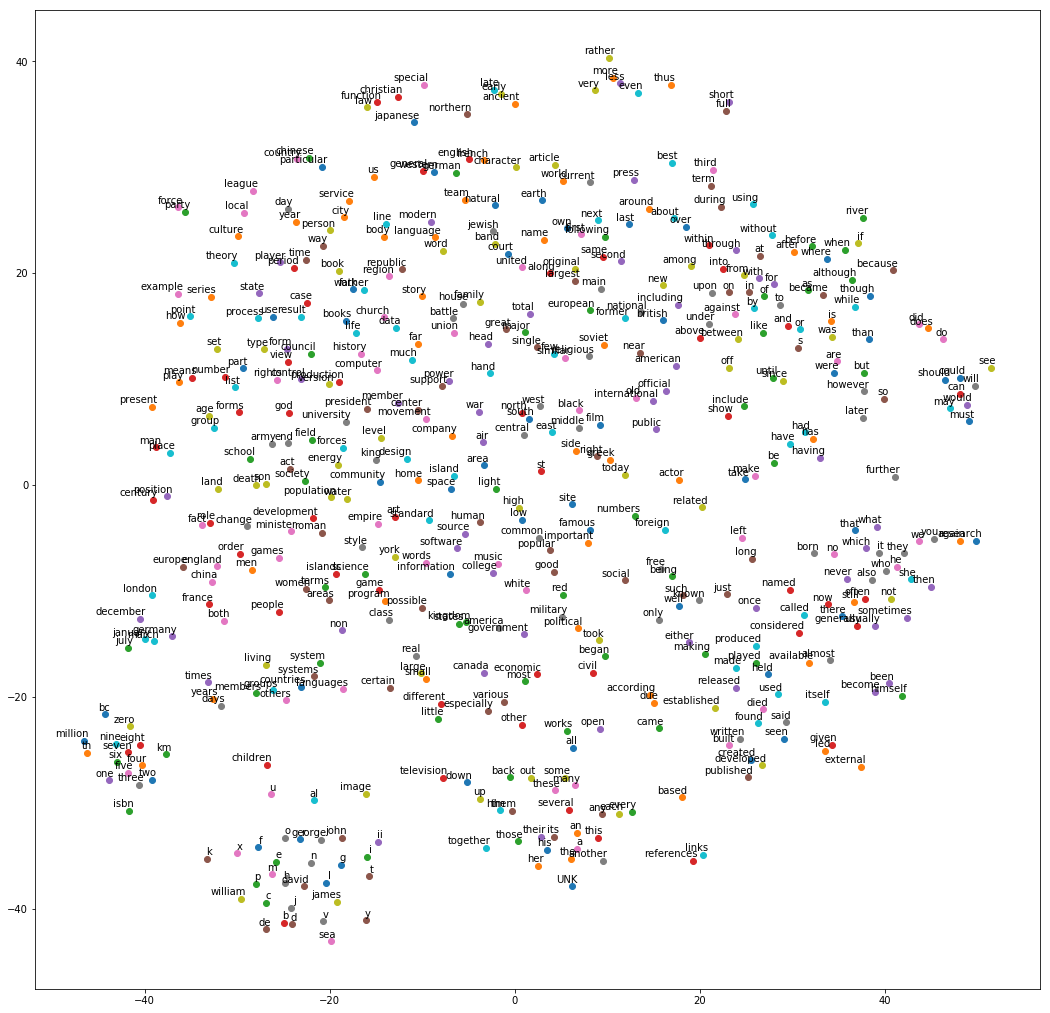

In [49]:
# Train the CBOW model in this block. Display the output for submission.

train_inputs, train_labels, loss, normalized_embeddings, valid_similarity = word2vec_cbow(vocab_size, embed_size)
generate_batch_fn = partial(generate_batch_cbow, **batch_function_kwargs)

# Call the training loop
final_embeddings = train_embedding_model(train_inputs, 
                                         train_labels, 
                                         loss, 
                                         normalized_embeddings, 
                                         valid_similarity, 
                                         generate_batch_fn, 
                                         num_steps)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

Initialized the computational graph.
Average loss at step  0 :  109.29022979736328
Nearest to such: puritans, horthy, precedent, censorship, ironically, ethnological, unscientific, mcveigh,
Nearest to many: belleville, paula, acceptors, antigua, soir, handbuch, lyricist, beets,
Nearest to system: knebworth, drab, bergman, taliaferro, bestiaries, emblem, fend, juventus,
Nearest to known: pasquale, fishermen, spade, deprogramming, mir, hemophilia, jamestown, habitability,
Nearest to from: explored, converted, temporarily, gangster, deploying, thrace, feeding, essence,
Nearest to the: challengers, scumm, try, shortcut, orcas, taverns, hegelian, corsairs,
Nearest to about: snub, bambaataa, raised, tailor, widowed, anarcha, restructure, ascendancy,
Nearest to and: walters, dexter, argonne, moraines, xyz, lasting, romana, ringworld,
Nearest to up: relativistic, leaching, interspersed, gymnasium, housewife, physiology, paradoxes, eastbound,
Nearest to states: rewrote, kegan, appeal, rabi, bau

Average loss at step  48000 :  2.915169700458646
Average loss at step  50000 :  3.1290075545459985
Nearest to such: well, include, parentage, puritans, revoluci, an, shoe, bewildering,
Nearest to many: its, some, several, a, these, an, their, which,
Nearest to system: bell, assembled, dedicated, kremlin, amplifiers, relativism, softness, millikan,
Nearest to known: notch, grigory, intercal, panorama, quickly, used, an, gymnosperms,
Nearest to from: of, by, for, with, in, on, to, at,
Nearest to the: a, UNK, an, their, his, and, its, many,
Nearest to about: bambaataa, bajan, anarcha, scrupulous, fyrom, herbivores, correspondences, optimism,
Nearest to and: of, by, for, from, on, UNK, with, to,
Nearest to up: rcaf, orloff, travelers, inquiring, submits, outboard, physiology, confederate,
Nearest to states: rewrote, kegan, rabi, bauhaus, telecommunication, syllable, handicraft, celeste,
Nearest to have: are, had, be, were, has, was, who, that,
Nearest to world: outcasts, pluriform, cuneifo

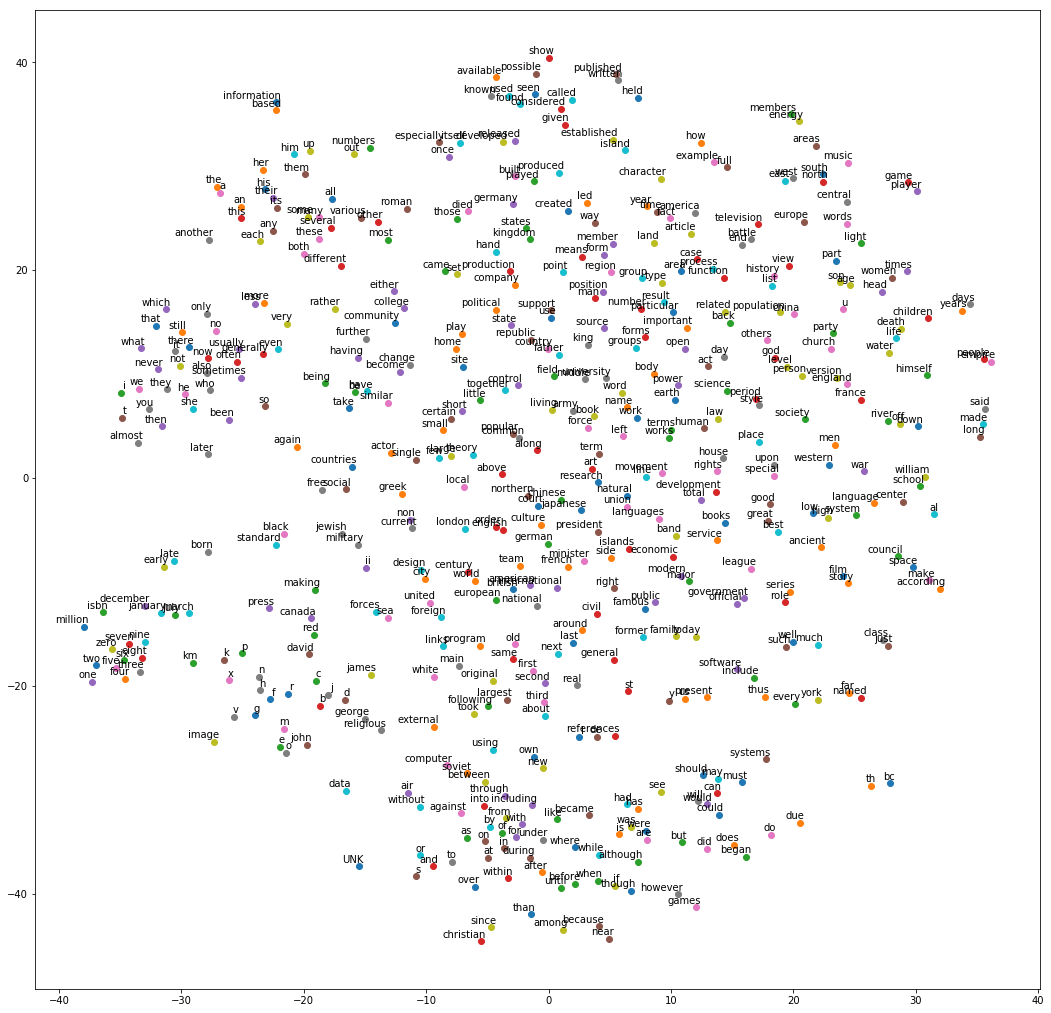

In [52]:
# Train the Skip-Gram model in this block. Display the output for submission.

train_inputs, train_labels, loss, normalized_embeddings, valid_similarity = word2vec_skipgram(vocab_size, embed_size)
generate_batch_fn = partial(generate_batch_skipgram, **batch_function_kwargs)

# Call the training loop
final_embeddings = train_embedding_model(train_inputs, 
                                         train_labels, 
                                         loss, 
                                         normalized_embeddings, 
                                         valid_similarity, 
                                         generate_batch_fn, 
                                         num_steps)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [ ]:
 teng, inquired, ig, wrote, diligently, ballots, dendritic, reinsurance,
    

## Q1C. Compare CBOW and Skip-Gram

**Did you notices any differences in training or evaluation between these two methods? Give a brief summary below.**

### Your written answer here!

# Part 2: Word Similarity & Analogies with Pretrained Word Embeddings

**Pretrained word embeddings** are word embeddings that have already been constructed in advance using some (usually task-agnostic) training procedure. The advantage of using off-the-shelf, pretrained word embeddings is that they are computationally simple to use (since no fine-tuning is required). The downside is that they may not be the best for the task we wish to apply them to. We can therefore evaluate the quality of pretrained embeddings by applying them to a specific downstream task such finding the word that is most similar to a given word, or analogical reasoning. The distance (Euclidean or cosine) between two word embeddings should measure the linguistic or semantic similarity of the corresponding words.

Here, we're using GloVe embeddings https://nlp.stanford.edu/projects/glove/ [4].

In [ ]:
import os
import numpy as np
import tensorflow as tf

def load_embeddings(filename):
    vocab = []
    embed = []
    with open(filename, 'r', encoding="utf-8") as f:
        for line in f.readlines():
            row = line.strip().split(' ')
            vocab.append(row[0])
            embed.append(row[1:])
    embed = np.asarray(embed)
    return vocab, embed

def read_analogies(analogy_filepath, word2id):
    questions = []
    with open(analogy_filepath, "r") as analogy_f:
        for line in analogy_f:
            if line.startswith(":"):  # Skip comments.
                continue
            words = line.strip().lower().split(" ")
            ids = [word2id.get(w.strip()) for w in words]
            if not (None in ids or len(ids) != 4):
                questions.append(np.array(ids))
    np.random.shuffle(questions)  # randomize the analogies
    return np.array(questions, dtype=np.int32)

# Load the GloVe vectors into numpy
glove_filepath = os.path.join('datasets', 'glove.6B.50d.txt')
vocab, embed = load_embeddings(glove_filepath)
vocab_size = len(vocab)
embed_dim = len(embed[0])
assert vocab_size > 0, "The vocabulary shouldn't be empty; did you download the GloVe weights?"
print('Loaded %d %d-dimensional embeddings.' % (vocab_size, embed_dim))

word2id = {}
id2word = vocab
for i, w in enumerate(id2word):
    word2id[w] = i

# Load the analogies
analogies = read_analogies(os.path.join('datasets', 'questions-words.txt'), word2id)
assert analogies.shape[0] > 0, "The matrix of analogies shouldn't be empty; did you download the analogies?"
print('Loaded %d analogies.' % analogies.shape[0])

# Ops to load the embeddings into TensorFlow
embedding = tf.Variable(tf.constant(0.0, shape=[vocab_size, embed_dim]),
                        trainable=False, name="embedding")
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embed_dim])
embedding_init = embedding.assign(embedding_placeholder)

## Q2A. Similar words & antonyms

By learning word embeddings that encode distributional information, we can make use of the principle that *similar words appear in similar contexts*. In paritcular, similar words should have similar embeddings. **Verify this fact by finishing the implementation of a method that find the words with minimum cosine distance to the embedding of a given word in the vocabulary.**

However, one known problem with word embeddings is that antonyms (words with meanings considered to be opposites) often have similar embeddings. You can verify this by searching for an antonym in the top *k* most similar words to a given word. **Find at least 3 such word-antonym pairs with similar embeddings, and give a textual justification for why this occurs in word embedding models.**

### Your written answer here!

In [ ]:
def word_pairs(embedding):
    
    target = tf.placeholder(dtype=tf.int32)
    
    ### Find the top most similar words
    ### YOUR CODE HERE
    #normalizing
    embedding = embedding/tf.reshape(tf.norm(embedding,axis=1),(-1,1))
    target_embedding = tf.gather(embedding, target)
    distances = tf.matmul(target_embedding,embedding, transpose_b=True)
    ### END YOUR CODE
    ### ... distances should a vector of size [vocab_size] containing
    ### the distances of the target d to each word in the vocabulary
    
    # Return top 10 as a representative sample
    _, top_k_idx = tf.nn.top_k(distances, 10)
    
    return target, top_k_idx

In [ ]:
# Runtime commands

### Define some target words for which to look up similar words
### YOUR CODE HERE
targets = ['friends','people','france','movies']
### END YOUR CODE

targets = [word2id[target] for target in targets]

with get_session() as sess:
    
    # Initialize the embedding matrix
    sess.run(embedding_init, feed_dict={embedding_placeholder: embed})

    # Create the ops to complete the analogy
    target_placeholder, top_idx = word_pairs(embedding)

    # Complete some analogies!
    for i, target in enumerate(targets):
        idx = sess.run(top_idx, {target_placeholder: [target]})
        print("Word #%d: %s" % (i + 1, target))
        print("\t%s" % ', '.join([id2word[j] for j in idx[0]]))
        print('')

## Q2B. Solving the analogy task


The analogy task that makes use of the  is as follows: Given a triplet of words $w_a$, $w_b$ and $w_c$, select the appropriate word $w_d$ to complete the following analogy:

<center>$w_a$ is to $w_b$ as $w_c$ is to ???.</center>

An example task woud be is: "Man is to woman as king is to ???"; the correct answer is "queen". Mikolov et al. [2013a] proposed that simple algebraic operations could be applied to vector space embeddings to solve such an analogy task. For $w_d$ that completes the analogy, we expect that

$$v_{w_b} - v_{w_a} \approx v_{w_d} - v_{w_c}$$

i.e., that *the difference between $w_b$ and $w_a$ is similar to the difference between $w_d$ and $w_c$*. The $w_d$ that we would like is therefore

$$v_{w_d} = \arg \max_{w_d \in \mathcal{V} \setminus \{w_a, w_b, w_c\}}
\cos \left(v_{w_d}, v_{w_b} - v_{w_a} + v_{w_c}\right)~. \tag{3}$$

For this question, implement the analogy prediction method described in (3) by completing the skeleton below.

In [ ]:
def complete_analogy(embedding):
    
    a = tf.placeholder(dtype=tf.int32)
    b = tf.placeholder(dtype=tf.int32)
    c = tf.placeholder(dtype=tf.int32)
    
    ### We need to use the embeddings to solve the analogy task
    ### "a is to b as c is to d"
    ### for d (given a, b, and c)
    ### YOUR CODE HERE
    #normalizing
    embedding = embedding/tf.reshape(tf.norm(embedding,axis=1),(-1,1))
    a_emb = tf.gather(embedding,a)
    b_emb = tf.gather(embedding,b)
    c_emb = tf.gather(embedding,c)
    d_emb = b_emb - a_emb + c_emb
    distances = tf.matmul(d_emb,embedding, transpose_b=True)
    ### END YOUR CODE
    ### ... distances should a vector of size [vocab_size] containing
    ### the distances of the target d to each word in the vocabulary
    
    # Return top 4 in case we accidentally predict a, b or c
    _, top_k_idx = tf.nn.top_k(distances, 4)
    
    return a, b, c, top_k_idx

In [ ]:
# Runtime commands
with get_session() as sess:
    
    # Initialize the embedding matrix
    sess.run(embedding_init, feed_dict={embedding_placeholder: embed})

    # Create the ops to complete the analogy
    a_placeholder, b_placeholder, c_placeholder, top_idx = complete_analogy(embedding)

    # Complete some analogies!
    for i in range(10):
        w0, w1, w2, w3 = analogies[i]
        idx, = sess.run(top_idx, {
            a_placeholder: [w0],
            b_placeholder: [w1],
            c_placeholder: [w2]
        })
        a, b, c, d = [id2word[j] for j in [w0, w1, w2, w3]]
        print("Analogy #%d:" % (i + 1))
        for d_hat in [id2word[j] for j in idx]:
            if d_hat not in [a, b, c]:
                print('\t%s is to %s as %s is to %s\t(ground truth: %s)' % (a, b, c, d_hat, d))
                print('')
                break

# References
[1] Gutmann, Michael, and Aapo Hyvärinen. "Noise-contrastive estimation: A new estimation principle for unnormalized statistical models." In Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics, pp. 297-304. 2010. http://proceedings.mlr.press/v9/gutmann10a.html

[2] Mnih, Andriy, and Yee Whye Teh. "A fast and simple algorithm for training neural probabilistic language models." In Proceedings of the 29th International Conference
on Machine Learning, Edinburgh, Scotland, UK, 2012. https://arxiv.org/abs/1206.6426

[3] Mikolov, Tomas, Ilya Sutskever, Kai Chen, Greg S. Corrado, and Jeff Dean. "Distributed representations of words and phrases and their compositionality." In Advances in neural information processing systems, pp. 3111-3119. 2013.

[4] Pennington, Jeffrey, Richard Socher, and Christopher Manning. "Glove: Global vectors for word representation." In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP), pp. 1532-1543. 2014.